# Домашка 
---------------------------------------

tldr:
    
* Выбрать архитектуру из рассказанных NST, pix2pix, CycleGAN$^1$
* Подберите к ней задачу, чтобы она вам нравилась
* Подберите еще одну задачу, которая уже решена (если не NST)
* Повторите решение, которое уже есть$^2$ (если не NST)
* Решите свою задачу

---------------------------------------
1. Расположены в порядке возрастания сложности и крутизны
2. Поверьте если вы сделаете этот пункт следующий будет в *разы* легче

## Если вы выбрали Neural Style Transfer
---------------------------------------
Тут все довольно просто на первый и на второй взгляд. Поэтому недосотаточно просто написать свою функцию потерь и сдать ноутбук. Если вы хотите приличных баллов, то у вас есть две опции:


1. Вы разделяете картинку на две части и переносите на них разные стили. <p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала к одной чати картинки, а потом к другой.</span></p> От вас ожидается, что вы отдадите нейросети два картинки стиля и она внутри себя(скорее внутри лосс функции) разделит выходную картинку на две части и к одной части применит один стиль, а к другой - второй. 

2. Вы переносите *одновременно* два стиля на одну картинку контента.
<p><span style="color:red">Нельзя просто взять и два раза применить обычную архитектуру сначала с одним стилем, а потом с другим.</span></p>
От вас ожидается, что вы модифицируете модель(скорее лосс модели) для того, чтобы два стиля учитывались с разными весами. 

## Remarks:
-----------------------------------------

* Это задание нужно для того, чтобы вы наступили на все грабли, что есть. Узнали об их существовании и научились обходить. Посмотрели на неработающие модели и поняли, что все тлен. Изгуглили весь интернет и в конце заставили это все работать. Поверьте, оно того стиот. Не откладывайте это задание на ночь перед сдачей, так как весь смысл \*пуф\* улетучится.

* У вас два союзника в этой борьбе:
    1. Оригинальная статья, те психи, что ее писала как то заставили свою модель работать. Их мысли, которыми они спроводили свое детище, позволят вам написать свой вариант алгоритма. 
    2. Гугл, он знает ответы на почти все ваши вопросы, но у него есть две ипостаси одна простая в обещении и вы все ее занаете(русскоязычная), а есть еще одна, которая кусается, но знает больше(англоязычная). Если не знаете языва - учите на ходу :)
    
* На самом деле у вас есть еще один союзник, это ментор проекта(или лектор или семинарист). Его ресурсом нужно пользоваться в ситуации, в которой вы не можете(занчит попытались и не вышло) найти ответов, используя Гугл и статью.

* Сдавать это все нужно следующим образом. Код вы кидаете на github и отправляете ссылку туда, куда вам сказали(в телеграм, степик или еще куда-то)

##Neural Style Transfer 

###Предварительные мероприятия:

Установим все необходимое:

In [ ]:
!pip3 install torch torchvision
!pip3 install pillow==4.1.1
%matplotlib inline
from types import *
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy
import os
import numpy as np

Подключимся к gDrive и зайдем в директорию:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('gdrive')
os.chdir('My Drive')
os.chdir('Gan and style transfer - homework')
os.listdir()
!ls images/

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
picture.jpg  style1.jpg  style2.jpg


Обозначим устройство.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Предобработка изображений и загрузчик:

In [ ]:
imsize = 256
loader = transforms.Compose([
                             transforms.Resize(imsize),
                             transforms.CenterCrop(imsize),
                             transforms.ToTensor()
])
def image_loader(image_name):
  image = Image.open(image_name)
  image = loader(image).unsqueeze(0) #Добавляем размерность(размер батча=1) для тензора
  return image.to(device, torch.float)

unloader = transforms.ToPILImage() #torch.Tensor to PILImage
plt.ion()#интерактивный режим для графиков - для того, чтобы не рисовать постоянно следующий, а обновлять старый

def imshow(tensor, title=None):
  image = tensor.cpu().clone()
  image = image.squeeze(0) #удалим размерность количества картинок, т.к рисуем одну
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

Загрузим фотки и отобразим их:

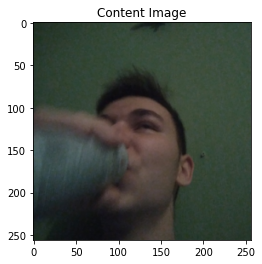

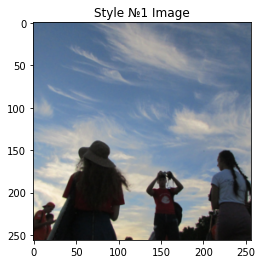

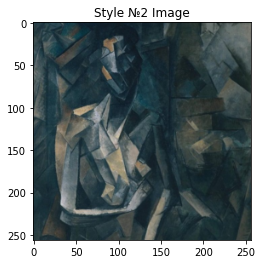

In [ ]:
style_img = image_loader("images/style2.jpg")
style2_img = image_loader("images/style1.jpg")
content_img = image_loader("images/picture.jpg")
imshow(content_img, title="Content Image")
imshow(style_img, "Style №1 Image")
imshow(style2_img, title="Style №2 Image")

Определим функцию для матрицы Грама:

In [ ]:
def gram_matrix(input):
  batch_size, h, w, f_map_num = input.size() # batch_size = 1
  #h, w - dimensions of a feature map
  #f_map_num - number of a future map
  features = input.view(batch_size * h, w * f_map_num)
  G = torch.mm(features, features.t()) #matrix multiplicate for gram matrix
  G = G.div(batch_size * h * w * f_map_num) #normalize Gramm matrix
  return G

Нормировка для VGG:

In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
  def __init__(self, mean, std):
    super(Normalization, self).__init__()
    self.mean = torch.tensor(mean).view(-1, 1, 1)
    self.std = torch.tensor(std).view(-1, 1, 1)
  def forward(self, img):
    return (img - self.mean) / self.std #normalize img

###Lite version


Объявим функции потерь:

In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach() #detach from calculation graph 
    self.loss = F.mse_loss(self.target, self.target) #some initialization
  
  def forward(self, input):
    self.loss = F.mse_loss(input, self.target) # mse from target image
                        # and content at the moment image
    return input

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.target = gram_matrix(target_feature).detach() #detach from calculation graph
    self.loss = F.mse_loss(self.target, self.target) #some initialization
  
  def forward(self, input):
    G = gram_matrix(input) #G-matrix features
    self.loss = F.mse_loss(G, self.target)
    return input

Определим обученную модель и оптимизатор:

In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
cnn = models.vgg19(pretrained=True).features.to(device).eval()
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [ ]:
cnn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Создаем модель с блоками функций потерь

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img, 
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
  cnn = copy.deepcopy(cnn)
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_lossL{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style_layers:
      target_feature = model(style_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  for i in range(len(model) -1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses


In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style_img, content_img)
  optimizer = get_input_optimizer(input_img)
  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)

      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(),
                                                         content_score.item()))
        print()
      return style_score + content_score

    optimizer.step(closure)
  input_img.data.clamp_(0, 1)
  return input_img

Запустим модель:

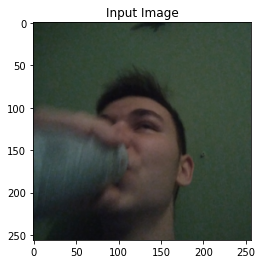

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss: 13.730284 Content Loss: 6.047436

run [100]:
Style Loss: 5.868824 Content Loss: 5.596456

run [150]:
Style Loss: 2.554671 Content Loss: 5.167904

run [200]:
Style Loss: 1.460444 Content Loss: 4.857349

run [250]:
Style Loss: 1.067971 Content Loss: 4.649399

run [300]:
Style Loss: 0.905129 Content Loss: 4.507535

run [350]:
Style Loss: 0.805408 Content Loss: 4.457808

run [400]:
Style Loss: 0.991091 Content Loss: 4.573526

run [450]:
Style Loss: 0.780071 Content Loss: 4.539242

run [500]:
Style Loss: 0.687143 Content Loss: 4.455419



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

Отобразим получившийся результат:

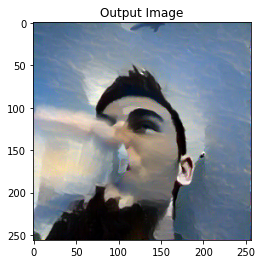

In [ ]:
plt.figure()
import numpy as np
imshow(output, title='Output Image')
plt.ioff()
plt.show()

###Модель с двумя стилями

Объявим функции потерь:

In [ ]:
#ContentLoss, StyleLoss, model & optimizer, get & run style transfer
class ContentLoss(nn.Module):
  def __init__(self, target):
    super(ContentLoss, self).__init__()
    self.target = target.detach()
    self.loss = F.mse_loss(self.target, self.target)

  def forward(self, input):
    self.loss = F.mse_loss(input, self.target)
    return input


In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target_feature):
    super(StyleLoss, self).__init__()
    self.G = gram_matrix(target_feature).detach()
    self.loss = F.mse_loss(self.G, self.G)
  
  def forward(self, input):
    self.loss = F.mse_loss(gram_matrix(input), self.G)
    return input

In [ ]:
content_layers_default = ['conv_4']
style1_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']
style2_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_5']
cnn = models.vgg19(pretrained=True).features.to(device).eval()
def get_input_optimizer(input_img):
  optimizer = optim.LBFGS([input_img.requires_grad_()])
  return optimizer

In [ ]:
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style1_img, style2_img, content_img, 
                               content_layers=content_layers_default,
                               style1_layers=style1_layers_default,
                               style2_layers=style2_layers_default):
  cnn = copy.deepcopy(cnn)#style_img
  normalization = Normalization(normalization_mean, normalization_std).to(device)
  content_losses = []
  style_losses = []
  model = nn.Sequential(normalization)

  i = 0
  for layer in cnn.children():
    if isinstance(layer, nn.Conv2d):
      i += 1
      name = 'conv_{}'.format(i)
    elif isinstance(layer, nn.ReLU):
      name = 'relu_{}'.format(i)
      layer = nn.ReLU(inplace=False)
    elif isinstance(layer, nn.MaxPool2d):
      name = 'pool_{}'.format(i)
    elif isinstance(layer, nn.BatchNorm2d):
      name = 'bn_{}'.format(i)
    else:
      raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

    model.add_module(name, layer)
    if name in content_layers:
      target = model(content_img).detach()
      content_loss = ContentLoss(target)
      model.add_module("content_lossL{}".format(i), content_loss)
      content_losses.append(content_loss)

    if name in style1_layers:
      target_feature = model(style1_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style1_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
    if name in style2_layers:
      target_feature = model(style2_img).detach()
      style_loss = StyleLoss(target_feature)
      model.add_module("style2_loss_{}".format(i), style_loss)
      style_losses.append(style_loss)
  for i in range(len(model) -1, -1, -1):
    if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
      break
  model = model[:(i+1)]
  return model, style_losses, content_losses


In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style1_img, style2_img, input_img, num_steps=500,
                       style_weight=100000, content_weight=1):
  print('Building the style transfer model..')
  model, style_losses, content_losses = get_style_model_and_losses(cnn, normalization_mean, normalization_std, style1_img, style2_img, content_img)
  optimizer = get_input_optimizer(input_img)
  print('Optimizing..')
  run = [0]
  while run[0] <= num_steps:
    def closure():
      input_img.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input_img)

      style_score = 0
      content_score = 0

      for sl in style_losses:
        style_score += sl.loss
      for cl in content_losses:
        content_score += cl.loss
      
      style_score *= style_weight
      content_score *= content_weight

      loss = style_score + content_score
      loss.backward()
      run[0] += 1
      if run[0] % 50 == 0:
        print('run {}:'.format(run))
        print('Style Loss: {:4f} Content Loss: {:4f}'.format(style_score.item(),
                                                         content_score.item()))
        print()
      return style_score + content_score

    optimizer.step(closure)
  input_img.data.clamp_(0, 1)
  return input_img

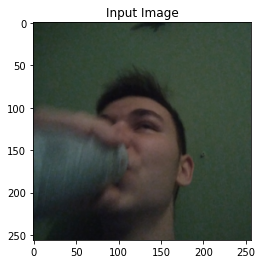

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Optimizing..
run [50]:
Style Loss: 47.775082 Content Loss: 6.805794

run [100]:
Style Loss: 41.132263 Content Loss: 5.831773

run [150]:
Style Loss: 39.123684 Content Loss: 5.241161

run [200]:
Style Loss: 38.558437 Content Loss: 4.828084

run [250]:
Style Loss: 38.176834 Content Loss: 4.626035

run [300]:
Style Loss: 37.923393 Content Loss: 4.511787

run [350]:
Style Loss: 37.715347 Content Loss: 4.452845

run [400]:
Style Loss: 37.561409 Content Loss: 4.407532

run [450]:
Style Loss: 37.444542 Content Loss: 4.376915

run [500]:
Style Loss: 37.347431 Content Loss: 4.364242



In [ ]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, style2_img, input_img)

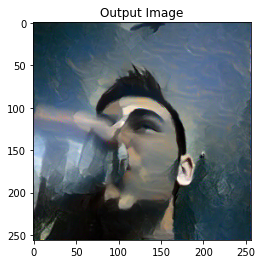

In [ ]:
plt.figure()
import numpy as np
imshow(output, title='Output Image')
plt.ioff()
plt.show()